## Welcome to the task!

First of all, here are some helper functions and constants which will come in later...

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.fft import rfft, rfftfreq, irfft

# This is the known sample rate used in the file in Hz
SAMPLE_RATE = 256
# This is the duration of the recording in seconds
SIGNAL_DURATION = 40
# As such, the total number of samples should be:
SAMPLES = SAMPLE_RATE * SIGNAL_DURATION


def load_signal(path="signal.npy"):
    with open(path, "rb") as f:
        signal = np.load(f)
    # This checks that the loaded file is the correct size
    assert signal.shape == (SAMPLES,)
    return signal


def plot_signal(signal, start=0, end=SIGNAL_DURATION):
    time = np.arange(0, end, 1 / SAMPLE_RATE)
    fig, axs = plt.subplots()
    axs.set_title("Signal")
    axs.plot(
        time, signal[int(start * SAMPLE_RATE) : int(end * SAMPLE_RATE)], color="C0"
    )
    axs.set_xlabel("Time")
    axs.set_ylabel("Amplitude")
    plt.show()
    
def remove_mains_interference(signal):
    #fourier transform
    yf = rfft(signal)
    xf = rfftfreq(SAMPLES, 1 / SAMPLE_RATE)
    
    print("Fourier transformed signal:")
    plt.plot(xf, np.abs(yf))
    plt.show()
    
    #filtering the signal (50Hz)
    points_per_freq = len(xf) / (SAMPLE_RATE / 2) # The maximum frequency is half the sample rate
    target_idx = int(points_per_freq * 50)
    yf[target_idx] = 0 #Set yf to 0 at indices where freq is 50Hz
    
    print("Cleaned fourier:")
    plt.plot(xf, np.abs(yf))
    plt.show()
    
    #inverse fourier transform
    cleaned_signal = irfft(yf)
    return(cleaned_signal)
    
def alpha(signal): #perform fourier transform and displays plot for frequencies 5-15Hz
    #fourier transform
    yf = rfft(signal)
    xf = rfftfreq(SAMPLES, 1 / SAMPLE_RATE)
    
    #plot
    print("Fourier transformed signal, between frequencies of 5 and 15Hz:")
    plt.axis(xmin=5, xmax=15)
    plt.plot(xf, np.abs(yf))
    plt.show()
 
    return xf, np.abs(yf)

def alpha_fourier(signal, n_samples): #perform fourier transform, no plot
    yf = rfft(signal)
    xf = rfftfreq(n_samples, 1 / SAMPLE_RATE)
    
    return xf, np.abs(yf)
    
def split_signal(sig, seg_duration):
    #splits signal, add parts to list
    sig_splits = []
    for i in range(0, len(sig), int(seg_duration * SAMPLE_RATE)):
        split = sig[i:i + seg_duration * SAMPLE_RATE] ##don't understand this line?
        if len(split) >= 1 * SAMPLE_RATE: #do I need this line?
            sig_splits.append(split)

    return sig_splits 

Now we can load the signal ready for you to get to work...

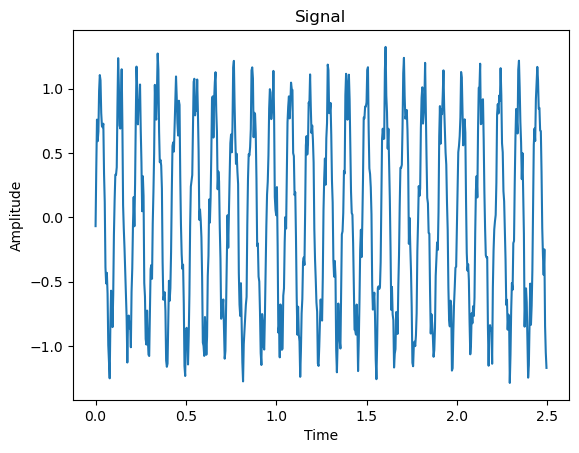

In [2]:
signal = load_signal()

# Show the first few seconds to check it's all okay...
plot_signal(signal, end=2.5)

Fourier transformed signal:


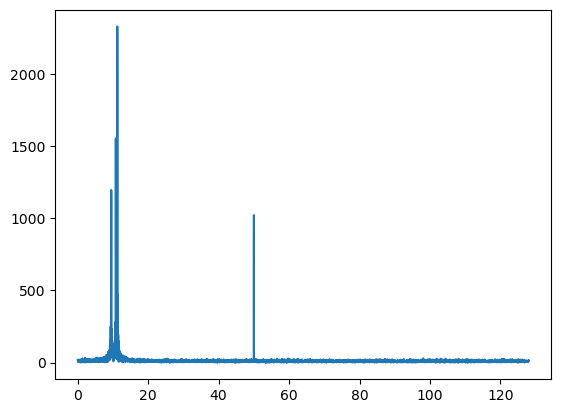

Cleaned fourier:


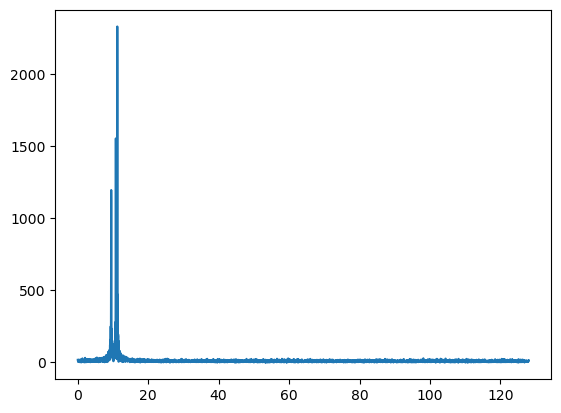

In [3]:
cleaned_signal = remove_mains_interference(signal)

Cleaned signal, plotted:

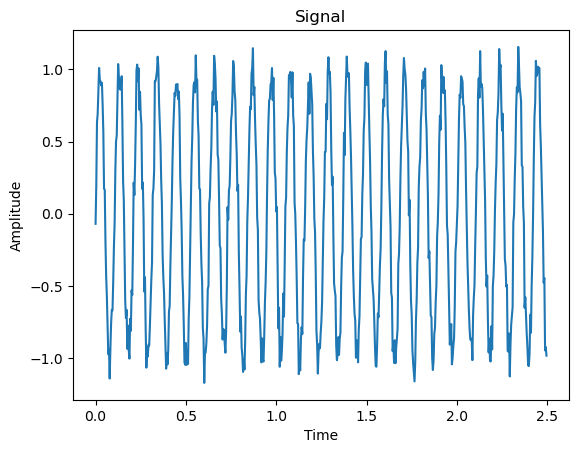

In [4]:
plot_signal(cleaned_signal, end=2.5)

### Looking for alpha wave component

Fourier transformed signal, between frequencies of 5 and 15Hz:


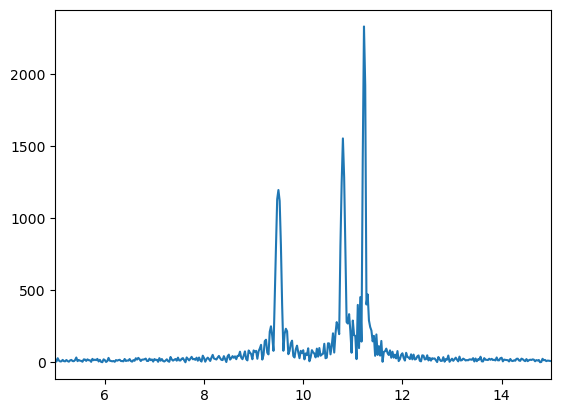

In [13]:
alpha_x, alpha_y = alpha(cleaned_signal)

### Investigating Alpha wave peaks

Heights of alpha wave peaks:

In [14]:
peak_indices, properties = sig.find_peaks(alpha_y, height = 1000,)
properties #peak heights, verify against fourier plot

{'peak_heights': array([1194.72240461, 1552.1372797 , 2327.63447378])}

Working backwards to find frequencies of these peaks

In [15]:
points_per_freq = len(alpha_x)/(SAMPLE_RATE/2)
peak_freqs = peak_indices/points_per_freq
peak_freqs

array([ 9.49814489, 10.79789104, 11.22280805])

### Do the frequencies of these peaks change over time?

In [52]:
signal_parts = split_signal(sig = cleaned_signal, seg_duration = 4)
n_samples = int(SAMPLES/10)
start_t = 0
end_t = 4
time_segments = []
freqs = []
heights = []

print("Alpha wave frequency and magnitude, every 4s:")

for part in signal_parts:
    time_segment = str(start_t) + "-" + str(end_t) #defining time segment being analysed
    alpha_x, alpha_y = alpha_fourier(part, n_samples) #perform fourier transform
    peak_indices, properties = sig.find_peaks(alpha_y, height = 100,) #look for peaks
    
    #finding peak frequencies
    points_per_freq = len(alpha_x)/(SAMPLE_RATE/2)
    peak_freqs = peak_indices/points_per_freq
    
    start_t +=4
    end_t +=4
    
    peak_n = 0 
    for peak in peak_freqs: #adding peak properties to list    
        time_segments.append(time_segment)
        freqs.append(peak_freqs[peak_n])
        heights.append(properties['peak_heights'][peak_n])
        peak_n += 1
    
d = {"time period (s)": time_segments, "peak frequency (Hz)": freqs, "peak height": heights}
df = pd.DataFrame(data = d) #creating df of peak properties
print(df)

Alpha wave frequency and magnitude, every 4s:
   time period (s)  peak frequency (Hz)  peak height
0              0-4             9.481481   514.221220
1              4-8             9.481481   509.968679
2             8-12             9.481481   169.814350
3             8-12            10.729045   322.476215
4            12-16            10.729045   478.318639
5            16-20            10.729045   483.549220
6            20-24            10.479532   156.556923
7            20-24            11.228070   376.447217
8            24-28            11.228070   509.056756
9            28-32            11.228070   506.633554
10           32-36            11.228070   508.844390
11           36-40            11.228070   507.082009


Alpha wave frequency increases with time (see report).

### Analysing signal amplitude

In [10]:
max(cleaned_signal)

1.3449355800685068

In [11]:
min(cleaned_signal)

-1.3379743279079133

# Report template for mysterious signal

## Alpha wave
As seen in the fourier transform above, the signal contains 3 distinct components between 8 and 12Hz. These all fall within the alpha wave range. Further analysis shows these peaks to be at 9.50Hz, 10.80Hz and 11.22Hz. 

How does the frequency of this alpha wave component change over time? 

The signal duration is 40 seconds, so I looked at how the composition of this alpha signal changes every 4 seconds (10 data points.) As time progressed, the frequency of the alpha wave increases, from 9.48Hz at the beginning of the signal, to 11.23Hz by the end. It also increases in steps, resulting in the 3 peaks seen on the fourier transform of the whole (unsegmented) signal. Some steps show a transition between frquencies, meaning that some time points have multiple peaks representing alpha waves.

## Other Properties
The signal amplitude (after removal of interference from the 50Hz mains) ranges from -1.34 to +1.34.